In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network

## Template 05
## Working with PyTorch - Flowers DataSet

<img src='../../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import random
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchsummary import summary
from torchvision import datasets
from torchvision.transforms import v2

#from utils.helper import fn_plot_torch_hist

In [3]:
def fn_plot_torch_hist(hist_df):
    
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]
    
    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset=y2)
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);
    
    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot
        
    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()


In [4]:
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth
        y_pred : Predictions
        labels : dictonary
                  {0: 'Goal Keeper',
                  1: 'Defender',
                  2: 'Mid-Fielder',
                  3: 'Forward'}

    '''

    cm  = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())

    fig, ax = plt.subplots(figsize = (6,6))

    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();

In [5]:
torch.__version__

'2.3.0'

In [6]:
import torchvision
torchvision.__version__

'0.18.0+cpu'

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cpu device


In [8]:
###----------------------
### Some basic parameters
###----------------------

inpDir = 'C:/Users/Administrator.DAI-PC2/Documents/DNN/input'
outDir = '../output'
modelDir = '../models'
subDir = 'flower_photos'
altName='torch_all_in'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results
np.random.seed(RANDOM_STATE)
EPOCHS = 201 # number of epochs

BATCH_SIZE = 16

ALPHA = 0.001 # learning rate

TRAIN_SIZE = (184*BATCH_SIZE) #<--- pay attention when changing BATCH_SIZE

TEST_SIZE=0.2

# Input Image size
IMG_HEIGHT = 186
IMG_WIDTH = 186

# for early stopping 
PATIENCE = 20
LR_FACTOR = 0.1
LR_PATIENCE = 10

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 4),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [9]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

In [10]:
def fn_showImages(img, ax):

    img = img.numpy().transpose((1,2,0)) # change to channel last

    means = np.array([0.485, 0.456, 0.406]) #mean as per transforms
    
    stds = np.array([0.229, 0.224, 0.225]) #std as per transform
    
    img = stds * img + means  #undo normalization
    
    img = np.clip(img, 0, 1) #clip values between [0,1]
    
    ax.imshow(img)
    ax.axis('off')

## Read Flowers data set

In [37]:
###---------------
### Transformation
###---------------

train_transform = v2.Compose([
    v2.Resize(IMG_HEIGHT),
    v2.RandomRotation(degrees=(-45,+45)), #AUgmentation
    v2.CenterCrop(IMG_HEIGHT),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize( mean = [0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  
])

test_transform = v2.Compose([
    v2.Resize(IMG_HEIGHT),
    v2.CenterCrop(IMG_HEIGHT),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize( mean = [0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  
])
#This is where we add data augmentation

data_dir = os.path.join(inpDir, subDir)

train_dataset = datasets.ImageFolder(data_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(data_dir, transform=test_transform)

In [39]:
image, label = next(iter(train_dataset))
image.shape, label

(torch.Size([3, 186, 186]), 0)

In [40]:
dataset_size = len(train_dataset)
indices= torch.randperm(dataset_size).tolist()

train_dataset= torch.utils.data.Subset(train_dataset, indices[:TRAIN_SIZE])

test_dataset= torch.utils.data.Subset(test_dataset, indices[TRAIN_SIZE:])

len(train_dataset), len(test_dataset)

(2944, 726)

In [15]:
class_names={count: nClass for count, nClass in enumerate(train_dataset.dataset.classes)}
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [16]:
train_dataloader= torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=True)

test_dataloader= torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=True)
trainSteps= len(train_dataloader.dataset) // BATCH_SIZE
testSteps= len(test_dataloader.dataset) // BATCH_SIZE

trainSteps, testSteps

(184, 45)

In [17]:
numClasses = len(class_names)
numClasses

5

In [18]:
#labels[i]

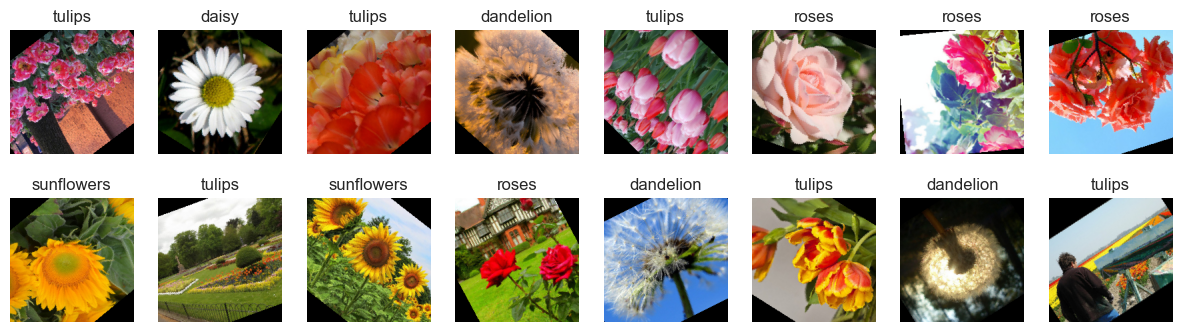

In [19]:
images, labels =next(iter(train_dataloader))

#print (images.shape, labels.shape)

fig = plt.figure()

for i in range (BATCH_SIZE):

    ax = fig.add_subplot(BATCH_SIZE//8, 8, i+1)
    
    fn_showImages(images[i], ax)

    ax.set_title(class_names[labels[i].item()])

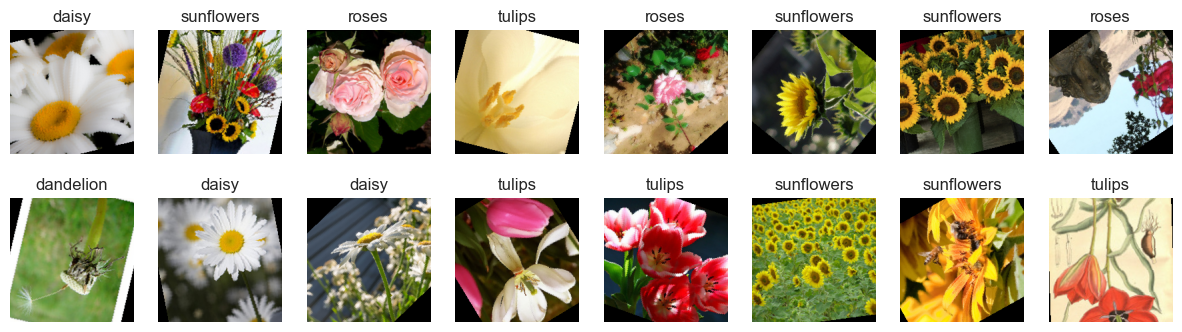

In [20]:
images, labels =next(iter(test_dataloader))

#print (images.shape, labels.shape)

fig = plt.figure()

for i in range (BATCH_SIZE):

    ax = fig.add_subplot(BATCH_SIZE//8, 8, i+1)
    
    fn_showImages(images[i], ax)

    ax.set_title(class_names[labels[i].item()])

In [21]:
class LeNet(nn.Module):
    def __init__(self, numChannels, classes):
        
        super(LeNet, self).__init__()
        
        #dropouts
        dor1= 0.3
        dor2= 0.3
        dor3= 0.4
        dor4= 0.5
        dor5= 0.5
        
        ##Define Layers
        #####Set 1
        out_channels1= 32
        #Conv ==> BN ==> LeakyRelu==> Pool==> Do
        self.conv1= nn.Conv2d(in_channels=numChannels,
                             out_channels= out_channels1,
                             kernel_size=(3,3))  #o/p shape= 184,184,128
        self.bn1= nn.BatchNorm2d(out_channels1)
        self.actv1= nn.LeakyReLU()
        self.maxpool1= nn.MaxPool2d(kernel_size=(4,4),
                                   stride=(4,4))    #ooutput_shape= 46 x 46 x32
        self.dropout1= nn.Dropout(p=dor1)
        
        #######Set 2
        out_channels2= 64
        #Conv ==> BN ==> LeakyRelu==> Pool==> Do
        self.conv2= nn.Conv2d(in_channels=out_channels1,
                             out_channels= out_channels2,
                             kernel_size=(3,3))  #o/p shape= 44, 44, 64
        self.bn2= nn.BatchNorm2d(out_channels2)
        self.actv2= nn.LeakyReLU()
        self.maxpool2= nn.MaxPool2d(kernel_size=(2,2),
                                   stride=(2,2))    #ooutput_shape= 22 x 22 x 64
        self.dropout2= nn.Dropout(p=dor2)
        
          #######Set 3
        out_channels3= 128
        #Conv ==> BN ==> LeakyRelu==> Pool==> Do
        self.conv3= nn.Conv2d(in_channels=out_channels2,
                             out_channels= out_channels3,
                             kernel_size=(3,3))  #o/p shape= 20, 20, 128
        self.bn3= nn.BatchNorm2d(out_channels3)
        self.actv3= nn.LeakyReLU()
        self.maxpool3= nn.MaxPool2d(kernel_size=(2,2),
                                   stride=(2,2))    #ooutput_shape= 10 x 10 x 128
        self.dropout3= nn.Dropout(p=dor3)
        
         #######Set 4
        out_channels4= 256
        #Conv ==> BN ==> LeakyRelu==> Pool==> Do
        self.conv4= nn.Conv2d(in_channels=out_channels3,
                             out_channels= out_channels4,
                             kernel_size=(3,3))  #o/p shape= 8, 8, 256
        self.bn4= nn.BatchNorm2d(out_channels4)
        self.actv4= nn.LeakyReLU()
        self.maxpool4= nn.MaxPool2d(kernel_size=(2,2),
                                   stride=(2,2))    #ooutput_shape= 4 x 4 x 256
        self.dropout4= nn.Dropout(p=dor4)
        
        ####HEAD
        out_channels5 = 512
        #Linear===> BN====> LeakyReLU====> Pool =======> Do
        self.fc1=nn.Linear(in_features= 4* 4* out_channels4,
                    out_features= out_channels5)
        self.bn5=nn.BatchNorm1d(out_channels5)
        self.actv5= nn.LeakyReLU()
        self.dropout5= nn.Dropout(p= dor5)
        
        #Final Output layer
        self.fc2=nn.Linear(in_features=out_channels5,
                          out_features= classes)
        self.logSoftmax= nn.LogSoftmax(dim=1)
        
    def forward(self,x):
        
        #pass through 1
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.actv1(x)
        x=self.maxpool1(x)
        x=self.dropout1(x)
        
        #pass through 2
        x=self.conv2(x)
        x=self.bn2(x)
        x=self.actv2(x)
        x=self.maxpool2(x)
        x=self.dropout2(x)
        
        #pass through 3
        x=self.conv3(x)
        x=self.bn3(x)
        x=self.actv3(x)
        x=self.maxpool3(x)
        x=self.dropout3(x)
        
        #pass through 4
        x=self.conv4(x)
        x=self.bn4(x)
        x=self.actv4(x)
        x=self.maxpool4(x)
        x=self.dropout4(x)
        
        #Flattening Layer
        x= torch.flatten(x,1)
        
        #Head fully connected layers
        x=self.fc1(x)
        x=self.bn5(x)
        x=self.actv5(x)
        x=self.dropout5(x)
        
        #ourtput
        x= self.fc2(x)
        return self.logSoftmax(x)
        

In [22]:
numChannels=3


model= LeNet(numChannels = numChannels, classes=numClasses).to(device)

summary(model, (numChannels, IMG_HEIGHT, IMG_WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 184, 184]             896
       BatchNorm2d-2         [-1, 32, 184, 184]              64
         LeakyReLU-3         [-1, 32, 184, 184]               0
         MaxPool2d-4           [-1, 32, 46, 46]               0
           Dropout-5           [-1, 32, 46, 46]               0
            Conv2d-6           [-1, 64, 44, 44]          18,496
       BatchNorm2d-7           [-1, 64, 44, 44]             128
         LeakyReLU-8           [-1, 64, 44, 44]               0
         MaxPool2d-9           [-1, 64, 22, 22]               0
          Dropout-10           [-1, 64, 22, 22]               0
           Conv2d-11          [-1, 128, 20, 20]          73,856
      BatchNorm2d-12          [-1, 128, 20, 20]             256
        LeakyReLU-13          [-1, 128, 20, 20]               0
        MaxPool2d-14          [-1, 128,

In [23]:
#initialize our optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(),
                             lr=ALPHA)

loss_fn = nn.CrossEntropyLoss()

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         factor=LR_FACTOR,
                                                         patience=LR_PATIENCE,
                                                         min_lr=1e-5)

#Initialize a dictionary to store training history
H = {
    'Epoch'     :[],
    'Train Loss':[],
    'Test Loss' :[],
    'Train Acc' :[],
    'Test Acc'  :[],
    'Alpha'     :[],
    'Patience'  :[]
}
print('done')

done


In [43]:
#Min Loss
minLoss =  float('inf')

#Path to save the model
savePath = os.path.join(modelDir, subDir, 'flowers.pth')

#Train models for multiple epochs
for epoch in range(EPOCHS):
        epochStart = time.time()

        #Trainig loop
        train_loss = 0.0
        train_acc = 0.0

        for i, data in enumerate(train_dataloader):
            model.train()

            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs  = model(inputs)

            preds = torch.argmax(outputs, dim = 1)

            batch_loss = loss_fn(outputs, labels)
            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

            batch_loss.backward()
            optimizer.step()

            train_loss += batch_loss.item() * inputs.size(0)
            train_acc += batch_acc * inputs.size(0)

        train_loss /= len(train_dataset)
        train_acc /= len(train_dataset)

        H['Train Loss'].append(train_loss)
        H['Train Acc'].append(train_acc)

        ##Testing loop
        test_loss = 0.0
        test_acc = 0.0

        with torch.no_grad():
            model.eval()

            for data in test_dataloader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

            outputs  = model(inputs)

            preds = torch.argmax(outputs, dim = 1)

            batch_loss = loss_fn(outputs, labels)
            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())


            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc * inputs.size(0)

        test_loss/= len(test_dataset)
        test_acc /= len(test_dataset)

        H['Test Loss'].append(test_loss)
        H['Test Acc'].append(test_acc)
    H['Epoch'].append(epoch)  

    #Step the scheduler
    lr_scheduler.step(test_loss)

    ##Add early stopping/ saving model
    if test_loss < minLoss:
        minLoss = test_loss
        counter = 0

        #Saving model
        torch.save({'epoch': epoch + 1,
                   'model_state_dict': model.state_dict(),
                   'optimizer_state_dict': optimizer.state_dict(),
                   'loss': loss_fn,}, savePath)
    else:
        counter += 1
    if counter > PATIENCE:
            break
        ######
    curr_alpha = lr_scheduler.get_last_lr()[0]
    H['Alpha'].append(curr_alpha)

    H['Patience'].append(counter)

    if epoch%2 == 0:
            #Print the model training and validation information
    print(f"Epoch: {epoch:3d}/{EPOCHS:3d}", end = ' ')
    print(f"Loss: {train_loss:6f}/{test_loss:.6f}, Accuracy: {train_acc:.4f}/{test_acc:.4f}", end = ' ')
    print(f"Alpha: {curr_alpha:.6f}, ES: {counter:2d}", end = ' ')
    print(f'Epoch time: {time.time() - epochStart:.2f} Sec')


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 71)

In [ ]:
fn_plot_torch_hist(loss_df)